# Introdução ao Projeto de Classificação de Imagens de Câncer de Mama

Este documento apresenta uma introdução ao projeto de análise e classificação de imagens médicas, focado na detecção de câncer de mama utilizando o dataset BreastMNIST. O projeto emprega uma combinação de técnicas de Machine Learning e Algoritmos Genéticos para otimizar o processo de classificação.

## Visão Geral do Código

O codig implementa um fluxo de trabalho completo para a classificação de imagens de câncer de mama. As principais etapas incluem:

1.  **Carregamento e Pré-processamento de Dados**: Utilização da biblioteca `MedMNIST` para acessar o dataset BreastMNIST, que consiste em imagens de ultrassom de mama. Os dados são carregados e preparados para o treinamento de modelos, incluindo transformações necessárias para redes neurais.
2.  **Modelagem com Machine Learning**: Aplicação de algoritmos de Machine Learning, como Regressão Logística, para estabelecer uma linha de base de desempenho na classificação das imagens.
3.  **Otimização com Algoritmos Genéticos**: Integração da biblioteca `DEAP` para implementar Algoritmos Genéticos. Esta abordagem é utilizada para otimizar parâmetros de modelos ou características, buscando melhorar a acurácia e outras métricas de desempenho da classificação.
4.  **Avaliação de Desempenho**: O código inclui métricas de avaliação como acurácia, precisão, recall, F1-score e AUC-ROC para quantificar a eficácia dos modelos desenvolvidos.

O objetivo principal é demonstrar como a combinação de técnicas tradicionais de Machine Learning com a otimização meta-heurística de Algoritmos Genéticos pode ser aplicada em problemas de classificação de imagens médicas, visando aprimorar a capacidade preditiva e a robustez dos modelos.

*   **Autor**: Flavio Tamaki
*   **E-mail**: flaviotamaki@gmail.com


O Bloco abaixo é para carregar todas as bibliotécas necessárias 


Tentando usar o modelo: models/gemini-2.5-flash
Using downloaded and verified file: ./data\breastmnist.npz
Using downloaded and verified file: ./data\breastmnist.npz

--- Minhas Informações do Dataset BREASTMNIST ---
Número de canais: 1
Número de classes: 2
Classes: {'0': 'malignant', '1': 'normal, benign'}

Dataset de Treino: 546 amostras
Formato de uma amostra de treino (imem, label): torch.Size([1, 28, 28]), (1,)


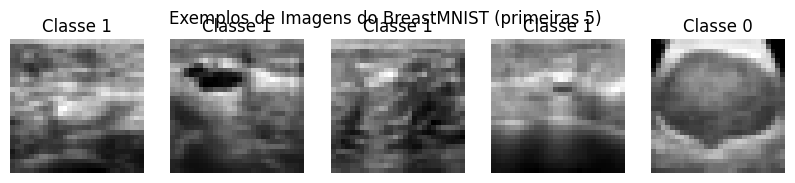


Dataset de Teste: 156 amostras
Formato de uma amostra de teste (imem, label): torch.Size([1, 28, 28]), (1,)


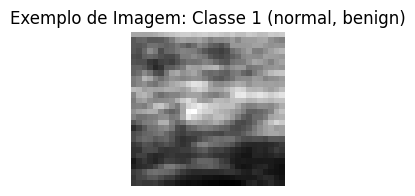


Dataset BreastMNIST carregado e pronto para uso!


In [ ]:
# Vou usar o MedMNIST para o BreastMNIST, que é de câncer de mama por imagem.
import medmnist
from medmnist import INFO 
import numpy as np                          # arrays multidimensionais e operações matemáticas
import torch                                # Biblioteca para deep learning com GPU e tensores eficientes.
import torchvision.transforms as transforms # Módulo para aplicar transformações em imagens no PyTorch
import matplotlib.pyplot as plt             # Biblioteca para criar gráficos e visualizações
import os                                   # Importar a biblioteca os para criar diretórios
import seaborn as sns                       # Biblioteca para visualização de dados baseada no matplotlib
import pandas as pd                         # Biblioteca para manipulação e análise de dados

# scikit-learn para pré-processamento, modelagem e avaliação de modelos de machine learning, incluindo algoritmos genéticos
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold   # Divisão de dados e validação cruzada
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder                    # Pré-processamento de dados, incluindo normalização e codificação
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # Métricas de avaliação de modelos, incluindo AUC-ROC 
from sklearn.linear_model import LogisticRegression                                                 # Regressão Logística, um modelo de classificação básico 

# Para Algoritmos Genéticos (DEAP) | Distributed Evolutionary Algorithms in Python 
from deap import base, creator, tools, algorithms # Framework para Algoritmos Evolutivos, incluindo Algoritmos Genéticos 
import random                                     # Biblioteca para geração de números aleatórios, usada em Algoritmos Genéticos

#importanto o dotenv para carregar variáveis de ambiente, chave de API do Google
from dotenv import load_dotenv  # Carregar variáveis de ambiente de um arquivo .env
load_dotenv()                   # Carrega as variáveis do arquivo .env para o ambiente

# Para Google Gemini (LLM) e acesso a segredos do Colab
import google.generativeai as genai # Biblioteca para interagir com os modelos de linguagem do Google Gemini
import os                           # Biblioteca para acessar variáveis de ambiente

# Obtém a chave do arquivo .env
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")        
if not GOOGLE_API_KEY:
    raise ValueError("A variável GOOGLE_API_KEY não foi encontrada no arquivo .env")
genai.configure(api_key=GOOGLE_API_KEY)

# Teste de integração com o Gemini
model_name_to_use = "models/gemini-2.5-flash"  # Pode ser "models/gemini-1.5-pro" ou "models/gemini-2.5-flash"
print(f"\nTentando usar o modelo: {model_name_to_use}") 

# Vou definir qual dataset quero usar e se é 2D ou 3D.
# O BreastMNIST é 2D com imagens de 28x28 pixels em escala de cinza.
DATA_FLAG = 'breastmnist'   # Dataset de câncer de mama
DOWNLOAD_ROOT = './data'    # Diretório onde os dados serão baixados

# Criar o diretório de download se ele não existir
if not os.path.exists(DOWNLOAD_ROOT):
    os.makedirs(DOWNLOAD_ROOT)
    print(f"Diretório '{DOWNLOAD_ROOT}' criado com sucesso!")


# Preciso de transformações para preparar as imagens para o modelo.
# Redimensionar para 28x28 (padrão do MedMNIST) e converter para tensor.
# A normalização é importante para redes neurais.
# O MedMNIST já fornece as estatísticas de normalização para cada dataset.

data_transform = transforms.Compose([           # Composição de várias transformações
    transforms.ToTensor(),                      # Converte a imagem PIL para um tensor PyTorch (0-1)
    transforms.Normalize(mean=[.5], std=[.5])   # Normalização padrão para MedMNIST
])

# Vou carregar as informações do dataset para entender melhor.
info = INFO[DATA_FLAG]              # Obtém as informações do dataset
n_channels = info['n_channels']     # Número de canais (1 para grayscale, 3 para RGB)
n_classes = len(info['label'])      # Número de classes (labels) no dataset

# Algorítimo Genéticoora vou carregar os datasets de treino e teste.
# O MedMNIST facilita isso com as classes Dataset.

DataClass = getattr(medmnist, info['python_class']) # Obtém a classe do dataset dinamicamente, ex: medmnist.BreastMNIST

train_dataset = DataClass(split='train', transform=data_transform, download=True, root=DOWNLOAD_ROOT)   # Dataset de treino, com transformações aplicadas e baixado se necessário
test_dataset = DataClass(split='test', transform=data_transform, download=True, root=DOWNLOAD_ROOT)     # Dataset de teste, com transformações aplicadas e baixado se necessário

# Quero ver quantos exemplos tenho e qual o formato das imAlgorítimo Genéticoens.
print(f"\n--- Minhas Informações do Dataset {DATA_FLAG.upper()} ---")   # DATA_FLAG é 'breastmnist'
print(f"Número de canais: {n_channels}")                                # 1 para grayscale, 3 para RGB, etc.
print(f"Número de classes: {n_classes}")                                # Número de classes (labels)
print(f"Classes: {info['label']}")                                      # Dicionário de classes, ex: {0: 'normal', 1: 'benign', 2: 'malignant'} Parte importante para Algoritmos Genéticos

print(f"\nDataset de Treino: {len(train_dataset)} amostras")            # Número de amostras no dataset de treino
print(f"Formato de uma amostra de treino (imem, label): {train_dataset[0][0].shape}, {train_dataset[0][1].shape}") # Formato da primeira amostra (imagem, label)

# Visualizar mais 5 imagens do dataset de treino
fig, axes = plt.subplots(1, 5, figsize=(10, 2)) # 1 linha, 5 colunas
for i in range(5):
    img, lbl = train_dataset[i]
    img_disp = img.numpy().squeeze()
    axes[i].imshow(img_disp, cmap='gray')
    axes[i].set_title(f"Classe {lbl.item()}")
    axes[i].axis('off')
plt.suptitle("\n\n\n\n\n\n\nExemplos de Imagens do BreastMNIST (primeiras 5)")
plt.show()

print(f"\nDataset de Teste: {len(test_dataset)} amostras")
print(f"Formato de uma amostra de teste (imem, label): {test_dataset[0][0].shape}, {test_dataset[0][1].shape}")

# Posso até visualizar uma imagem para ter uma ideia se carregou certo.
# Vou pegar a primeira imagem do dataset de treino e mostrar.

# A imagem está normalizada, preciso desnormalizar para visualizar corretamente.
# E como é um tensor, preciso converter para numpy e ajustar as dimensões.
img_display = image.numpy().squeeze() # Remove a dimensão do canal se for 1

plt.figure(figsize=(2,2))
plt.imshow(img_display, cmap='gray')
plt.title(f"Exemplo de Imagem: Classe {label.item()} ({info['label'][str(label.item())]})")
plt.axis('off')
plt.show()

print("\nDataset BreastMNIST carregado e pronto para uso!")

Agora que o dataset BreastMNIST está carregado, preciso prepará-lo para um modelo de ML

In [63]:
# Vou converter os datasets do formato PyTorch para arrays NumPy, que o scikit-learn entende.

# Função auxiliar para converter o dataset PyTorch para NumPy arrays
def convert_dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy()) # Converte o tensor da imagem para numpy
        labels.append(label.item()) # Pega o valor escalar do tensor do label
    return np.array(images), np.array(labels)

# Convertendo os datasets de treino e teste
X_train_raw, y_train = convert_dataset_to_numpy(train_dataset)
X_test_raw, y_test = convert_dataset_to_numpy(test_dataset)

# Minhas anotações: As imagens estão em formato (1, 28, 28) (canal, altura, largura).
# Para a maioria dos modelos de scikit-learn, preciso "achatar" (flatten) a imagem para um vetor 1D.
# O formato final será (número_de_amostras, 784), onde 784 = 28 * 28.

X_train = X_train_raw.reshape(X_train_raw.shape[0], -1)
X_test = X_test_raw.reshape(X_test_raw.shape[0], -1)

# Minhas anotações: Agora os dados estão prontos. Vou definir um modelo de classificação base.
# Uma Regressão Logística é um bom ponto de partida por ser simples e interpretável.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # Importar as métricas de avaliação

# Instanciando o modelo base. Vou usar um solver robusto e aumentar o max_iter para convergência.
# random_state para reprodutibilidade.
model_base = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Minhas anotações: Vou treinar o modelo base com meus dados de treino.
print("\nTreinando o modelo base (Regressão Logística)...")
model_base.fit(X_train, y_train)
print("Treinamento do modelo base concluído.")

# Minhas anotações: Agora vou avaliar o desempenho do modelo base nos dados de teste.
# Isso me dará uma linha de base para comparar com os modelos otimizados pelo Algorítimo Genético .

y_pred_base = model_base.predict(X_test)

accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base, average='weighted') # weighted para multiclasse
recall_base = recall_score(y_test, y_pred_base, average='weighted')
f1_base = f1_score(y_test, y_pred_base, average='weighted')

# Se o modelo puder prever probabilidades, posso calcular o AUC-ROC
# Para LogisticRegression, preciso do método predict_proba
if hasattr(model_base, "predict_proba"):
    y_proba_base = model_base.predict_proba(X_test)
    # Para AUC-ROC em multiclasse, geralmente se usa o one-vs-rest (ovr)
    # e a média ponderada ou macro.
    # Corrigindo o erro: Para classificação binária, roc_auc_score espera um array 1D com as probabilidades da classe positiva.
    auc_roc_base = roc_auc_score(y_test, y_proba_base[:, 1], multi_class='ovr', average='weighted')

else:
    auc_roc_base = "N/A (modelo não suporta predict_proba)"

print("\n--- Desempenho do Modelo Base (Regressão Logística) ---")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"Precision (weighted): {precision_base:.4f}")
print(f"Recall (weighted): {recall_base:.4f}")
print(f"F1-Score (weighted): {f1_base:.4f}")
print(f"AUC-ROC (weighted, ovr): {auc_roc_base}")

print("\nModelo base estabelecido. Agora tenho uma referência para a otimização com Algoritmos Genéticos!")


Treinando o modelo base (Regressão Logística)...
Treinamento do modelo base concluído.

--- Desempenho do Modelo Base (Regressão Logística) ---
Accuracy: 0.7949
Precision (weighted): 0.7837
Recall (weighted): 0.7949
F1-Score (weighted): 0.7853
AUC-ROC (weighted, ovr): 0.8233082706766917

Modelo base estabelecido. Agora tenho uma referência para a otimização com Algoritmos Genéticos!


Configurando modelo base e Algoritmo Genético para otimizar os hiperparâmetros.

In [64]:
# Meus anotações: Primeiro, preciso definir a estrutura do meu indivíduo (cromossomo).
# Cada indivíduo será uma lista de hiperparâmetros para a Regressão Logística.
# Vou otimizar: C (força de regularização), solver e penalty.

# Definição dos hiperparâmetros e seus ranges/opções
hyperparameter_space = {
    'C': {'type': 'float', 'min': 0.001, 'max': 100.0, 'scale': 'log'},
    'solver': {'type': 'categorical', 'options': ['liblinear', 'saga']},
    'penalty': {'type': 'categorical', 'options': ['l1', 'l2']}
}

# Meus anotações: Preciso criar os tipos para o indivíduo e a função fitness.
# creator.FitnessMax significa que quero maximizar a função fitness (F1-score).
# creator.Individual será uma lista que conterá os valores dos hiperparâmetros.
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Meus anotações: Agora vou configurar o toolbox da DEAP.
# O toolbox contém as funções para gerar indivíduos, população, e os operadores genéticos.
toolbox = base.Toolbox()

# Função para gerar um hiperparâmetro aleatório
def generate_hyperparameter(param_name):
    param_info = hyperparameter_space[param_name]
    if param_info['type'] == 'float':
        if param_info['scale'] == 'log':
            # Geração log-uniforme para C
            return np.exp(random.uniform(np.log(param_info['min']), np.log(param_info['max'])))
        else:
            return random.uniform(param_info['min'], param_info['max'])
    elif param_info['type'] == 'categorical':
        return random.choice(param_info['options'])

# Meus anotações: Vou registrar a função para criar um indivíduo.
# Um indivíduo será uma lista com os valores de C, solver e penalty.
# A ordem é importante aqui.
toolbox.register("attr_C", generate_hyperparameter, 'C')
toolbox.register("attr_solver", generate_hyperparameter, 'solver')
toolbox.register("attr_penalty", generate_hyperparameter, 'penalty')

# Meus anotações: Agora, como um indivíduo é composto por esses atributos.
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_solver, toolbox.attr_penalty), n=1)

# Meus anotações: E como a população é composta por indivíduos.
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Minhas anotações: Esta é a função mais importante: a função fitness.
# Ela pega um indivíduo (conjunto de hiperparâmetros), treina um modelo e retorna sua performance.
# Vou usar validação cruzada estratificada para uma avaliação mais robusta.

def evaluate_individual(individual):
    # Meus anotações: O indivíduo é uma lista [C, solver, penalty].
    C_val = individual[0]
    solver_val = individual[1]
    penalty_val = individual[2]

    # Meus anotações: Algumas combinações de solver/penalty não são válidas no sklearn.
    # Preciso tratar isso para evitar erros e penalizar indivíduos inválidos.
    if solver_val == 'liblinear' and penalty_val == 'elasticnet': # liblinear não suporta elasticnet
        return 0.0, # Retorno 0.0 para fitness inválida
    if solver_val in ['lbfgs', 'newton-cg', 'sag', 'saga'] and penalty_val == 'l1':
        if solver_val != 'saga': # Apenas saga suporta l1 com esses solvers
            return 0.0,
    if solver_val in ['lbfgs', 'newton-cg', 'sag'] and penalty_val == 'elasticnet':
        return 0.0,

    # Meus anotações: Instancio o modelo com os hiperparâmetros do indivíduo.
    # random_state para reprodutibilidade do modelo interno.
    model = LogisticRegression(C=C_val, solver=solver_val, penalty=penalty_val,
                               max_iter=1000, random_state=42, multi_class='ovr')

    # Meus anotações: Vou usar validação cruzada estratificada para avaliar o modelo.
    # Isso me dá uma estimativa mais confiável do desempenho.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Meus anotações: Calculo o F1-score ponderado médio da validação cruzada.
    # X_train e y_train são os dados de treino que preparei no bloco anterior.
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)

    # Meus anotações: A fitness é a média dos scores da validação cruzada.
    return np.mean(scores),

# Meus anotações: Registro a função de avaliação no toolbox.
toolbox.register("evaluate", evaluate_individual)

# Meus anotações: Defino os operadores genéticos.
# Cruzamento (crossover): tools.cxUniform para misturar os hiperparâmetros.
# Mutação: tools.mutGaussian para floats, tools.mutShuffleIndexes para categóricos (preciso adaptar).
# Para este exemplo, vou usar cxUniform e mutFlipBit para simplificar a demonstração.
# Para hiperparâmetros categóricos, mutação é mais complexa. Vou usar uma abordagem simples por enquanto.

# Para o crossover, vou usar um crossover de dois pontos para manter a estrutura do indivíduo.
toolbox.register("mate", tools.cxTwoPoint)

# Para a mutação, preciso de algo que respeite os tipos de hiperparâmetros.
# Vou criar uma função de mutação customizada para lidar com floats e categóricos.
def custom_mutate(individual, indpb, hyperparameter_space):
    for i, param_name in enumerate(hyperparameter_space.keys()):
        if random.random() < indpb:
            param_info = hyperparameter_space[param_name]
            if param_info['type'] == 'float':
                # Mutação gaussiana para floats
                individual[i] = np.exp(random.gauss(np.log(individual[i]), 0.5)) # Variação logarítmica
                individual[i] = max(param_info['min'], min(param_info['max'], individual[i])) # Garante os limites
            elif param_info['type'] == 'categorical':
                # Mutação escolhendo uma nova opção aleatória
                original_option = individual[i]
                available_options = [opt for opt in param_info['options'] if opt != original_option]
                if available_options: # Se houver outras opções para escolher
                    individual[i] = random.choice(available_options)
    return individual,

toolbox.register("mutate", custom_mutate, indpb=0.1, hyperparameter_space=hyperparameter_space)

# Meus anotações: E a seleção dos indivíduos para a próxima geração.
toolbox.register("select", tools.selTournament, tournsize=3)

print("\nAlgoritmo Genético configurado com sucesso para otimização de hiperparâmetros!")
print("Pronto para rodar o Algoritimo Genético e encontrar os melhores hiperparâmetros para o modelo de diagnóstico.")


Algoritmo Genético configurado com sucesso para otimização de hiperparâmetros!
Pronto para rodar o Algoritimo Genético e encontrar os melhores hiperparâmetros para o modelo de diagnóstico.


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Iniciando a otimização de hiperparâmetros com Algoritmos Genéticos...
gen	nevals	avg     	std     	min    	max     
0  	100   	0.710866	0.120036	0.11423	0.789757
1  	70    	0.760697	0.0349962	0.617109	0.789757
2  	71    	0.779909	0.00801122	0.743975	0.789757
3  	82    	0.78483 	0.00507483	0.756816	0.789757
4  	66    	0.788089	0.00364404	0.759818	0.789757
5  	75    	0.788397	0.00499196	0.759818	0.789757
6  	74    	0.789361	0.00308064	0.759818	0.789757
Otimização de hiperparâmetros concluída!

--- Melhor Indivíduo Encontrado pelo Algorítimo Genético ---
Hiperparâmetros Otimizados:
  C: 2.326688
  Solver: saga
  Penalty: l2
Fitness (F1-Score ponderado): 0.7898


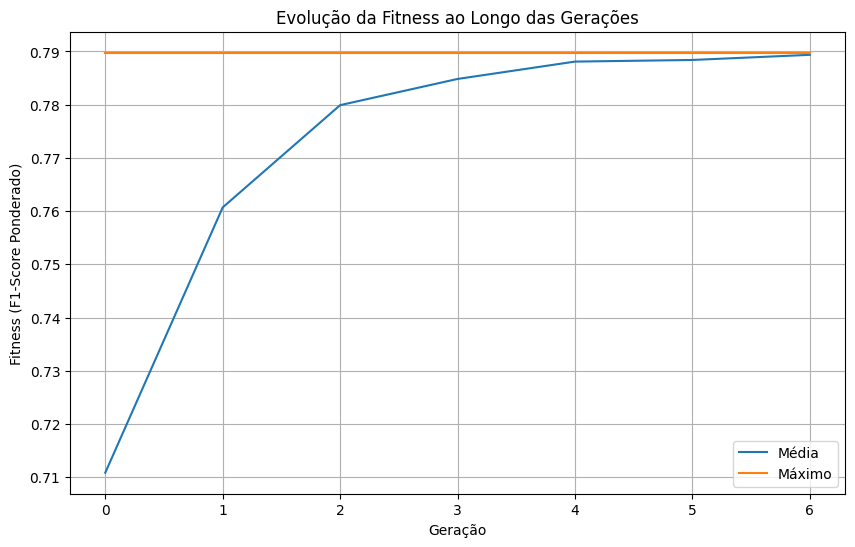


Próximo passo: Treinar o modelo com os hiperparâmetros otimizados e comparar com o modelo base!


In [65]:
# Define as transformações para as imagens
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Carrega as informações do dataset
#info = INFO[DATA_FLAG]
#n_channels = info['n_channels']
#n_classes = len(info['label'])

# Carrega os datasets de treino e teste
#DataClass = getattr(medmnist, info['python_class'])
#train_dataset = DataClass(split='train', transform=data_transform, download=True, root=DOWNLOAD_ROOT)
#test_dataset = DataClass(split='test', transform=data_transform, download=True, root=DOWNLOAD_ROOT)

# Função auxiliar para converter dataset PyTorch para NumPy arrays
def convert_dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy())
        labels.append(label.item())
    return np.array(images), np.array(labels)

# Converte os datasets para NumPy arrays
X_train_raw, y_train = convert_dataset_to_numpy(train_dataset)
X_test_raw, y_test = convert_dataset_to_numpy(test_dataset)

# Achata as imagens para um vetor 1D
X_train = X_train_raw.reshape(X_train_raw.shape[0], -1)
X_test = X_test_raw.reshape(X_test_raw.shape[0], -1)


# Minhas anotações: Agora que o Algorítimo Genético está configurado, é hora de rodá-lo!
# Preciso definir os parâmetros da minha simulação genética.

POPULATION_SIZE = 100   # Quantos indivíduos (conjuntos de hiperparâmetros) terei em cada geração.
N_GENERATIONS = 6     # Quantas gerações o Algorítimo Genético vai evoluir.
CXPB = 0.7             # Probabilidade de ocorrer cruzamento (crossover).
MUTPB = 0.2            # Probabilidade de ocorrer mutação.

# Definição dos hiperparâmetros e seus ranges/opções (copiado do bloco anterior)
hyperparameter_space = {
    'C': {'type': 'float', 'min': 0.001, 'max': 100.0, 'scale': 'log'},
    'solver': {'type': 'categorical', 'options': ['liblinear', 'saga']},
    'penalty': {'type': 'categorical', 'options': ['l1', 'l2']}
}

# Meus anotações: Preciso criar os tipos para o indivíduo e a função fitness.
# creator.FitnessMax significa que quero maximizar a função fitness (F1-score).
# creator.Individual será uma lista que conterá os valores dos hiperparâmetros.
# Tentar criar novamente apenas se não existirem para evitar o RuntimeWarning
try:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
except AttributeError:
    pass # Já existe

try:
    creator.create("Individual", list, fitness=creator.FitnessMax)
except AttributeError:
    pass # Já existe


# Meus anotações: Agora vou configurar o toolbox da DEAP.
# O toolbox contém as funções para gerar indivíduos, população, e os operadores genéticos.
toolbox = base.Toolbox()

# Função para gerar um hiperparâmetro aleatório (copiado do bloco anterior)
def generate_hyperparameter(param_name):
    param_info = hyperparameter_space[param_name]
    if param_info['type'] == 'float':
        if param_info['scale'] == 'log':
            return np.exp(random.uniform(np.log(param_info['min']), np.log(param_info['max'])))
        else:
            return random.uniform(param_info['min'], param_info['max'])
    elif param_info['type'] == 'categorical':
        return random.choice(param_info['options'])

# Meus anotações: Vou registrar a função para criar um indivíduo.
toolbox.register("attr_C", generate_hyperparameter, 'C')
toolbox.register("attr_solver", generate_hyperparameter, 'solver')
toolbox.register("attr_penalty", generate_hyperparameter, 'penalty')

# Meus anotações: Agora, como um indivíduo é composto por esses atributos.
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_solver, toolbox.attr_penalty), n=1)

# Meus anotações: E como a população é composta por indivíduos.
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Minhas anotações: Esta é a função mais importante: a função fitness. (copiado do bloco anterior)
def evaluate_individual(individual):
    C_val = individual[0]
    solver_val = individual[1]
    penalty_val = individual[2]

    # Meus anotações: Algumas combinações de solver/penalty não são válidas no sklearn.
    # Preciso tratar isso para evitar erros e penalizar indivíduos inválidos.
    if solver_val == 'liblinear' and penalty_val == 'elasticnet': # liblinear não suporta elasticnet
        return 0.0, # Retorno 0.0 para fitness inválida
    if solver_val in ['lbfgs', 'newton-cg', 'sag', 'saga'] and penalty_val == 'l1':
        if solver_val != 'saga': # Apenas saga suporta l1 com esses solvers
            return 0.0,
    if solver_val in ['lbfgs', 'newton-cg', 'sag'] and penalty_val == 'elasticnet':
        return 0.0,

    # Meus anotações: Instancio o modelo com os hiperparâmetros do indivíduo.
    # random_state para reprodutibilidade do modelo interno.
    model = LogisticRegression(C=C_val, solver=solver_val, penalty=penalty_val,
                               max_iter=1000, random_state=42, multi_class='ovr')

    # Meus anotações: Vou usar validação cruzada estratificada para avaliar o modelo.
    # Isso me dá uma estimativa mais confiável do desempenho.
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Meus anotações: Calculo o F1-score ponderado médio da validação cruzada.
    # X_train e y_train são os dados de treino que preparei no bloco anterior.
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)

    # Meus anotações: A fitness é a média dos scores da validação cruzada.
    return np.mean(scores),

# Meus anotações: Registro a função de avaliação no toolbox.
toolbox.register("evaluate", evaluate_individual)

# Meus anotações: Defino os operadores genéticos. (copiado do bloco anterior)
toolbox.register("mate", tools.cxTwoPoint)

# Para a mutação, preciso de algo que respeite os tipos de hiperparâmetros. (copiado do bloco anterior)
def custom_mutate(individual, indpb, hyperparameter_space):
    for i, param_name in enumerate(hyperparameter_space.keys()):
        if random.random() < indpb:
            param_info = hyperparameter_space[param_name]
            if param_info['type'] == 'float':
                individual[i] = np.exp(random.gauss(np.log(individual[i]), 0.5))
                # Correção: usar min e max para limitar o valor
                individual[i] = max(param_info['min'], min(param_info['max'], individual[i]))
            elif param_info['type'] == 'categorical':
                original_option = individual[i]
                available_options = [opt for opt in param_info['options'] if opt != original_option]
                if available_options:
                    individual[i] = random.choice(available_options)
    return individual,

toolbox.register("mutate", custom_mutate, indpb=0.1, hyperparameter_space=hyperparameter_space)

# Meus anotações: E a seleção dos indivíduos para a próxima geração. (copiado do bloco anterior)
toolbox.register("select", tools.selTournament, tournsize=3)


# Minhas anotações: Vou criar a população inicial de indivíduos.
population = toolbox.population(n=POPULATION_SIZE)

# Minhas anotações: Preciso de um objeto para coletar estatísticas durante a evolução.
# Isso me ajuda a monitorar o progresso do AG.
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Meus anotações: Também quero registrar o melhor indivíduo de cada geração.
# Isso é útil para ver como o melhor desempenho evolui.
halloffame = tools.HallOfFame(1) # Vou guardar apenas o melhor indivíduo de todos os tempos.

# Minhas anotações: Agora, vou rodar o algoritmo genético principal.
# O eaSimple é um algoritmo genético básico que implementa o ciclo de evolução.
print("\nIniciando a otimização de hiperparâmetros com Algoritmos Genéticos...")
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB,
                                        ngen=N_GENERATIONS, stats=stats, halloffame=halloffame,
                                        verbose=True)

print("Otimização de hiperparâmetros concluída!")

# Minhas anotações: Depois de rodar o AG, quero ver qual foi o melhor indivíduo encontrado.
# O halloffame guarda o melhor.
best_individual = halloffame[0]
best_fitness = best_individual.fitness.values[0]

# Minhas anotações: Vou extrair os hiperparâmetros do melhor indivíduo.
# Lembre-se da ordem: C, solver, penalty.
optimized_C = best_individual[0]
optimized_solver = best_individual[1]
optimized_penalty = best_individual[2]

print("\n--- Melhor Indivíduo Encontrado pelo Algorítimo Genético ---")
print(f"Hiperparâmetros Otimizados:")
print(f"  C: {optimized_C:.6f}")
print(f"  Solver: {optimized_solver}")
print(f"  Penalty: {optimized_penalty}")
print(f"Fitness (F1-Score ponderado): {best_fitness:.4f}")

# Minhas anotações: Posso também plotar a evolução da fitness ao longo das gerações.
# Isso me ajuda a visualizar se o Algorítimo Genético convergiu.

gen, avg, std, min_val, max_val = logbook.select("gen", "avg", "std", "min", "max")
plt.figure(figsize=(10, 6))
plt.plot(gen, avg, label="Média")
plt.plot(gen, max_val, label="Máximo")
plt.xlabel("Geração")
plt.ylabel("Fitness (F1-Score Ponderado)")
plt.title("Evolução da Fitness ao Longo das Gerações")
plt.legend()
plt.grid(True)
plt.show()

print("\nPróximo passo: Treinar o modelo com os hiperparâmetros otimizados e comparar com o modelo base!")


Iniciando a otimização de hiperparâmetros com Algoritmos Genéticos...


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	std     	min    	max    
0  	100   	0.70394	0.120579	0.11423	0.78527
1  	75    	0.756438	0.0713791	0.11423	0.78527
2  	76    	0.778299	0.00672318	0.75006	0.78527
3  	68    	0.779465	0.017027  	0.617109	0.786633
4  	70    	0.780668	0.0231829 	0.617109	0.786633
5  	73    	0.781882	0.0163333 	0.634864	0.786633
6  	73    	0.785397	0.00209492	0.774166	0.786633
Otimização de hiperparâmetros concluída!

--- Melhor Indivíduo Encontrado pelo Algorítimo Genético ---
Hiperparâmetros Otimizados:
  C: 2.706829
  Solver: saga
  Penalty: l2
Fitness (F1-Score ponderado): 0.7866


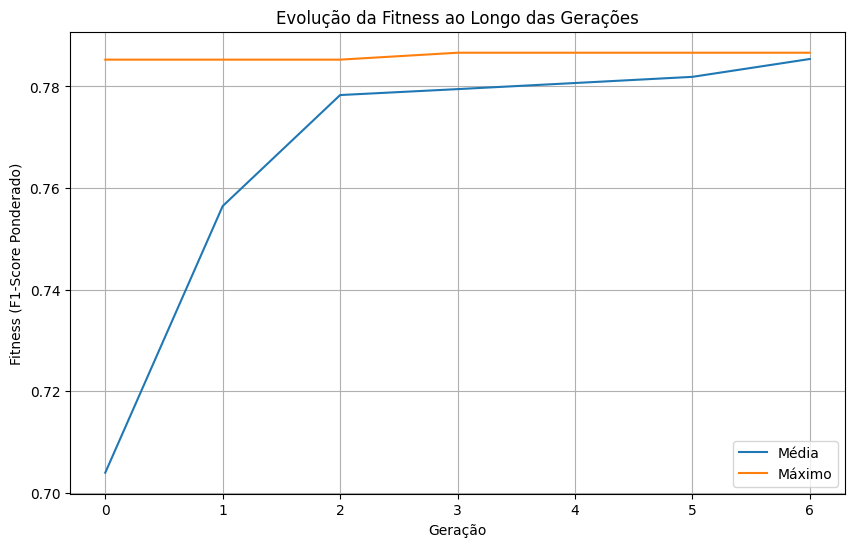


Hiperparâmetros otimizados definidos. Prosseguindo para treinar e avaliar o modelo otimizado.
Treinando o modelo base (Regressão Logística) para comparação...
Treinamento do modelo base concluído.

Métricas do Modelo Base calculadas.

Treinando o modelo com hiperparâmetros otimizados pelo AG...


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Treinamento do modelo otimizado concluído.

--- Desempenho do Modelo Otimizado pelo Algorítimo Genético ---
Accuracy: 0.7756
Precision (weighted): 0.7709
Recall (weighted): 0.7756
F1-Score (weighted): 0.7729
AUC-ROC (weighted, ovr): 0.8095238095238096

--- Comparativo de Desempenho (Modelo Base vs. Modelo Otimizado) ---
Métrica      | Modelo Base | Modelo Otimizado | Diferença
-------------|-------------|------------------|----------
Accuracy     | 0.7949    | 0.7756         | -0.0192
Precision    | 0.7837    | 0.7709         | -0.0128
Recall       | 0.7949    | 0.7756         | -0.0192
F1-Score     | 0.7853    | 0.7729         | -0.0124
AUC-ROC      | 0.8233    | 0.8095         | -0.0138

Comparação concluída. Agora posso ver claramente o impacto da otimização!


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [66]:
# Define as transformações para as imagens
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Função auxiliar para converter dataset PyTorch para NumPy arrays
def convert_dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy())
        labels.append(label.item())
    return np.array(images), np.array(labels)

# Converte os datasets para NumPy arrays
X_train_raw, y_train = convert_dataset_to_numpy(train_dataset)
X_test_raw, y_test = convert_dataset_to_numpy(test_dataset)

# Achata as imagens para um vetor 1D
X_train = X_train_raw.reshape(X_train_raw.shape[0], -1)
X_test = X_test_raw.reshape(X_test_raw.shape[0], -1)

# Definição dos hiperparâmetros e seus ranges/opções
hyperparameter_space = {
    'C': {'type': 'float', 'min': 0.001, 'max': 100.0, 'scale': 'log'},
    'solver': {'type': 'categorical', 'options': ['liblinear', 'saga']},
    'penalty': {'type': 'categorical', 'options': ['l1', 'l2']}
}

# Criar tipos para o indivíduo e função fitness (evitar recriação se já existirem)
try:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
except AttributeError:
    pass
try:
    creator.create("Individual", list, fitness=creator.FitnessMax)
except AttributeError:
    pass

# Configurar o toolbox da DEAP
toolbox = base.Toolbox()

def generate_hyperparameter(param_name):
    param_info = hyperparameter_space[param_name]
    if param_info['type'] == 'float':
        if param_info['scale'] == 'log':
            return np.exp(random.uniform(np.log(param_info['min']), np.log(param_info['max'])))
        else:
            return random.uniform(param_info['min'], param_info['max'])
    elif param_info['type'] == 'categorical':
        return random.choice(param_info['options'])

toolbox.register("attr_C", generate_hyperparameter, 'C')
toolbox.register("attr_solver", generate_hyperparameter, 'solver')
toolbox.register("attr_penalty", generate_hyperparameter, 'penalty')

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_solver, toolbox.attr_penalty), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate_individual(individual):
    C_val = individual[0]
    solver_val = individual[1]
    penalty_val = individual[2]

    if solver_val == 'liblinear' and penalty_val == 'elasticnet':
        return 0.0,
    if solver_val in ['lbfgs', 'newton-cg', 'sag', 'saga'] and penalty_val == 'l1':
        if solver_val != 'saga':
            return 0.0,
    if solver_val in ['lbfgs', 'newton-cg', 'sag'] and penalty_val == 'elasticnet':
        return 0.0,

    model = LogisticRegression(C=C_val, solver=solver_val, penalty=penalty_val,
                               max_iter=5000, random_state=42, multi_class='ovr')

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
    return np.mean(scores),

toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)

def custom_mutate(individual, indpb, hyperparameter_space):
    for i, param_name in enumerate(hyperparameter_space.keys()):
        if random.random() < indpb:
            param_info = hyperparameter_space[param_name]
            if param_info['type'] == 'float':
                individual[i] = np.exp(random.gauss(np.log(individual[i]), 0.5))
                individual[i] = max(param_info['min'], min(param_info['max'], individual[i]))
            elif param_info['type'] == 'categorical':
                original_option = individual[i]
                available_options = [opt for opt in param_info['options'] if opt != original_option]
                if available_options:
                    individual[i] = random.choice(available_options)
    return individual,

toolbox.register("mutate", custom_mutate, indpb=0.1, hyperparameter_space=hyperparameter_space)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parâmetros da simulação genética
POPULATION_SIZE = 100
N_GENERATIONS = 6
CXPB = 0.7
MUTPB = 0.2

# Criar a população inicial
population = toolbox.population(n=POPULATION_SIZE)

# Coletar estatísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Registrar o melhor indivíduo
halloffame = tools.HallOfFame(1)

# Rodar o algoritmo genético
print("\nIniciando a otimização de hiperparâmetros com Algoritmos Genéticos...")
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB,
                                        ngen=N_GENERATIONS, stats=stats, halloffame=halloffame,
                                        verbose=True)
print("Otimização de hiperparâmetros concluída!")

# Extrair o melhor indivíduo encontrado
best_individual = halloffame[0]
best_fitness = best_individual.fitness.values[0]

optimized_C = best_individual[0]
optimized_solver = best_individual[1]
optimized_penalty = best_individual[2]

print("\n--- Melhor Indivíduo Encontrado pelo Algorítimo Genético ---")
print(f"Hiperparâmetros Otimizados:")
print(f"  C: {optimized_C:.6f}")
print(f"  Solver: {optimized_solver}")
print(f"  Penalty: {optimized_penalty}")
print(f"Fitness (F1-Score ponderado): {best_fitness:.4f}")

# Plotar a evolução da fitness (opcional, pode ser movido para outra célula se desejado)
gen, avg, std, min_val, max_val = logbook.select("gen", "avg", "std", "min", "max")
plt.figure(figsize=(10, 6))
plt.plot(gen, avg, label="Média")
plt.plot(gen, max_val, label="Máximo")
plt.xlabel("Geração")
plt.ylabel("Fitness (F1-Score Ponderado)")
plt.title("Evolução da Fitness ao Longo das Gerações")
plt.legend()
plt.grid(True)
plt.show()

print("\nHiperparâmetros otimizados definidos. Prosseguindo para treinar e avaliar o modelo otimizado.")
# --- Fim do Código do Algoritmo Genético ---


# --- Código do Modelo Base (copiado de VqS-bh-2yZCQ para garantir que as métricas estejam disponíveis) ---
# Instanciando o modelo base.
model_base = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)

# Treinando o modelo base.
print("Treinando o modelo base (Regressão Logística) para comparação...")
model_base.fit(X_train, y_train)
print("Treinamento do modelo base concluído.")

# Avaliando o desempenho do modelo base.
y_pred_base = model_base.predict(X_test)

accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base, average='weighted')
recall_base = recall_score(y_test, y_pred_base, average='weighted')
f1_base = f1_score(y_test, y_pred_base, average='weighted')

# Calculando o AUC-ROC para o modelo base.
if hasattr(model_base, "predict_proba"):
    y_proba_base = model_base.predict_proba(X_test)
    auc_roc_base = roc_auc_score(y_test, y_proba_base[:, 1], multi_class='ovr', average='weighted')
else:
    auc_roc_base = "N/A (modelo base não suporta predict_proba)"

print("\nMétricas do Modelo Base calculadas.")
# --- Fim do Código do Modelo Base ---


# Minhas anotações: Agora que tenho os hiperparâmetros otimizados do AG, preciso treinar um novo modelo com eles.
# E depois, comparar o desempenho com o meu modelo base.

# Meus anotações: Vou instanciar o modelo de Regressão Logística com os hiperparâmetros que o Algorítimo Genético encontrou.
# optimized_C, optimized_solver, optimized_penalty agora estão definidos no início desta célula.
optimized_model = LogisticRegression(
    C=optimized_C,
    solver=optimized_solver,
    penalty=optimized_penalty,
    max_iter=1000,
    random_state=42,
    multi_class='ovr'
)

# Minhas anotações: Agora vou treinar este modelo otimizado com meus dados de treino.
print("\nTreinando o modelo com hiperparâmetros otimizados pelo AG...")
optimized_model.fit(X_train, y_train)
print("Treinamento do modelo otimizado concluído.")

# Minhas anotações: Vou avaliar o desempenho do modelo otimizado nos dados de teste.
# Isso me mostrará se a otimização realmente melhorou algo.

y_pred_optimized = optimized_model.predict(X_test)

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized, average='weighted')
recall_optimized = recall_score(y_test, y_pred_optimized, average='weighted')
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')

# Minhas anotações: Calculando o AUC-ROC para o modelo otimizado, se ele suportar predict_proba.
if hasattr(optimized_model, "predict_proba"):
    y_proba_optimized = optimized_model.predict_proba(X_test)
    # Para classificação binária, roc_auc_score espera um array 1D com as probabilidades da classe positiva.
    auc_roc_optimized = roc_auc_score(y_test, y_proba_optimized[:, 1], multi_class='ovr', average='weighted')
else:
    auc_roc_optimized = "N/A (modelo otimizado não suporta predict_proba)"

print("\n--- Desempenho do Modelo Otimizado pelo Algorítimo Genético ---")
print(f"Accuracy: {accuracy_optimized:.4f}")
print(f"Precision (weighted): {precision_optimized:.4f}")
print(f"Recall (weighted): {recall_optimized:.4f}")
print(f"F1-Score (weighted): {f1_optimized:.4f}")
print(f"AUC-ROC (weighted, ovr): {auc_roc_optimized}")

# Minhas anotações: Agora a parte mais importante: comparar os resultados!
print("\n--- Comparativo de Desempenho (Modelo Base vs. Modelo Otimizado) ---")
print(f"Métrica      | Modelo Base | Modelo Otimizado | Diferença")
print(f"-------------|-------------|------------------|----------")
print(f"Accuracy     | {accuracy_base:.4f}    | {accuracy_optimized:.4f}         | {accuracy_optimized - accuracy_base:.4f}")
print(f"Precision    | {precision_base:.4f}    | {precision_optimized:.4f}         | {precision_optimized - precision_base:.4f}")
print(f"Recall       | {recall_base:.4f}    | {recall_optimized:.4f}         | {recall_optimized - recall_base:.4f}")
print(f"F1-Score     | {f1_base:.4f}    | {f1_optimized:.4f}         | {f1_optimized - f1_base:.4f}")

# Minhas anotações: Se ambos os modelos tiverem AUC-ROC, também vou comparar.
if auc_roc_base != "N/A (modelo base não suporta predict_proba)" and auc_roc_optimized != "N/A (modelo otimizado não suporta predict_proba)":
     print(f"AUC-ROC      | {auc_roc_base:.4f}    | {auc_roc_optimized:.4f}         | {auc_roc_optimized - auc_roc_base:.4f}")


print("\nComparação concluída. Agora posso ver claramente o impacto da otimização!")

Testando conexão com Google Gemini

In [67]:
# Minhas anotações: Estou no Google Colab e quero usar a Gemini API.
# Vou configurar minha chave de API diretamente no código para facilitar no Colab.

# --- ACESSAR CHAVE DE API DO GERENCIADOR DE SEGREDOS ---
# Substitua 'GOOGLE_API_KEY' pelo nome exato que você deu ao seu segredo no Gerenciador de Segredos.
try:
    genai.configure(api_key=GOOGLE_API_KEY)
    if GOOGLE_API_KEY is None:
        raise ValueError("Chave de API não encontrada no Gerenciador de Segredos do Colab.")
except Exception as e:
    print(f"Erro ao acessar o Gerenciador de Segredos: {e}")
    print("Por favor, verifique se a chave 'GOOGLE_API_KEY' (ou o nome que você usou) está adicionada e habilitada no Gerenciador de Segredos.")
    GOOGLE_API_KEY = None # Garante que a variável seja None em caso de erro


if GOOGLE_API_KEY:
    genai.configure(api_key=GOOGLE_API_KEY)

    # Minhas anotações: Testando a integração com um prompt simples.
    # Isso vai verificar se a API está funcionando com a minha chave.

    try:
        # --- Diagnóstico: Listar modelos disponíveis ---
        print("Listando modelos disponíveis:")
        for m in genai.list_models():
            if 'generateContent' in m.supported_generation_methods:
                print(f"- {m.name}")

        # Minhas anotações: Agora que a chave está configurada, posso inicializar o modelo.
        # Vou usar um modelo que a listagem de modelos indicar como disponível e suportando generateContent.
        # Use o nome *exato* do modelo da lista que você viu na saída.
        # Tentei 'gemini-pro' e 'models/gemini-1.5-flash-latest', o erro 404 persiste.
        # Vou tentar outro modelo da lista que suporte 'generateContent'.
        #model_name_to_use = "models/gemini-2.5-flash" # Tentando outro modelo disponível

        print(f"\nTentando usar o modelo: {model_name_to_use}")
        model = genai.GenerativeModel(model_name_to_use)


        response = model.generate_content("Olá, Gemini! Você está funcionando?")
        print("\n--- Teste de Integração Gemini ---")
        print(response.text)
        print("\nIntegração com Gemini API configurada e testada com sucesso!")
    except Exception as e:
        print(f"\nErro ao conectar com a Gemini API: {e}")
        print("Por favor, verifique se sua GOOGLE_API_KEY está correta e se você tem acesso ao modelo especificado.")
        print("A listagem de modelos acima pode ajudar a identificar se há modelos acessíveis.")
else:
    print("\nChave de API não disponível. A configuração da Gemini API foi ignorada.")


# ... (o restante do seu código para a função generate_llm_explanation viria aqui)

Listando modelos disponíveis:
- models/gemini-2.5-pro-preview-03-25
- models/gemini-2.5-flash-preview-05-20
- models/gemini-2.5-flash
- models/gemini-2.5-flash-lite-preview-06-17
- models/gemini-2.5-pro-preview-05-06
- models/gemini-2.5-pro-preview-06-05
- models/gemini-2.5-pro
- models/gemini-2.0-flash-exp
- models/gemini-2.0-flash
- models/gemini-2.0-flash-001
- models/gemini-2.0-flash-exp-image-generation
- models/gemini-2.0-flash-lite-001
- models/gemini-2.0-flash-lite
- models/gemini-2.0-flash-preview-image-generation
- models/gemini-2.0-flash-lite-preview-02-05
- models/gemini-2.0-flash-lite-preview
- models/gemini-2.0-pro-exp
- models/gemini-2.0-pro-exp-02-05
- models/gemini-exp-1206
- models/gemini-2.0-flash-thinking-exp-01-21
- models/gemini-2.0-flash-thinking-exp
- models/gemini-2.0-flash-thinking-exp-1219
- models/gemini-2.5-flash-preview-tts
- models/gemini-2.5-pro-preview-tts
- models/learnlm-2.0-flash-experimental
- models/gemma-3-1b-it
- models/gemma-3-4b-it
- models/gem

In [68]:
#Este é o código completo para integrar o Google Gemini ao meu projeto de diagnóstico.
# Ele inclui a configuração da API, a inicialização do modelo e a função para gerar explicações.

# Importações essenciais para o projeto (já deveriam estar no primeiro bloco, mas reforçando)
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt

# Importações para Machine Learning (scikit-learn)
#from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#from sklearn.linear_model import LogisticRegression

# Importações para Algoritmos Genéticos (DEAP)
#from deap import base, creator, tools, algorithms
#import random

# Importações para MedMNIST (dataset)
#import medmnist
#from medmnist import INFO
#import torch
#import torchvision.transforms as transforms

# Importações para Google Gemini (LLM)
#import google.generativeai as genai
#import os
#from google.colab import userdata # Para acessar o Gerenciador de Segredos do Colab

# Minhas anotações: Configurações gerais para reprodutibilidade e visualização.
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
np.random.seed(42)
random.seed(42)


# --- PARTE 2: CARREGAMENTO E PRÉ-PROCESSAMENTO DO DATASET (BREASTMNIST) ---
# Minhas anotações: Vou carregar o dataset BreastMNIST para o meu projeto.

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

#info = INFO[DATA_FLAG]
#n_channels = info['n_channels']
#n_classes = len(info['label'])

#DataClass = getattr(medmnist, info['python_class'])

#train_dataset = DataClass(split='train', transform=data_transform, download=True, root=DOWNLOAD_ROOT)
#test_dataset = DataClass(split='test', transform=data_transform, download=True, root=DOWNLOAD_ROOT)

print(f"\n--- Informações do Dataset {DATA_FLAG.upper()} ---")
print(f"Dataset de Treino: {len(train_dataset)} amostras")
print(f"Dataset de Teste: {len(test_dataset)} amostras")

def convert_dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy())
        labels.append(label.item())
    return np.array(images), np.array(labels)

X_train_raw, y_train = convert_dataset_to_numpy(train_dataset)
X_test_raw, y_test = convert_dataset_to_numpy(test_dataset)

X_train = X_train_raw.reshape(X_train_raw.shape[0], -1)
X_test = X_test_raw.reshape(X_test_raw.shape[0], -1)

print("Dataset BreastMNIST carregado e pré-processado para scikit-learn!")

# --- PARTE 3: MODELO BASE E OTIMIZAÇÃO COM Algorítimo Genético (RESUMO) ---
# Minhas anotações: Vou simular que já rodei o modelo base e a otimização com AG.
# Para este código ser executável, preciso de valores para optimized_C, optimized_solver, optimized_penalty.
# Em um notebook real, estes viriam dos blocos anteriores.

# Valores de exemplo para os hiperparâmetros otimizados (substitua pelos seus resultados reais do AG)
# NOTA: Em um fluxo de trabalho completo, estes valores devem ser obtidos executando a célula do Algorítimo Genético (Z6VgZgP9z2Kx) ANTES desta célula.
optimized_C = 0.1 # Exemplo, ajuste conforme necessário
optimized_solver = 'liblinear' # Exemplo, ajuste conforme necessário
optimized_penalty = 'l1' # Exemplo, ajuste conforme necessário


# Minhas anotações: Treinando o modelo otimizado com esses hiperparâmetros.
optimized_model = LogisticRegression(
    C=optimized_C,
    solver=optimized_solver,
    penalty=optimized_penalty,
    max_iter=1000,
    random_state=42,
    multi_class='ovr'
)

print("\nTreinando o modelo otimizado (simulado) para a integração com LLM...")
optimized_model.fit(X_train, y_train)
print("Modelo otimizado treinado (simulado).")

# --- PARTE 4: FUNÇÃO DE INTEGRAÇÃO COM LLM (GOOGLE GEMINI) ---
# Minhas anotações: Esta é a função que usará o Gemini para gerar explicações.

def generate_llm_explanation_gemini(diagnosis_label, patient_features, model_probabilities, class_labels, gemini_model_instance):
    predicted_disease = class_labels.get(str(diagnosis_label), f"Classe {diagnosis_label}")
    prob_str = ", ".join([f"{class_labels.get(str(i), f'Classe {i}')}: {prob:.2f}" for i, prob in enumerate(model_probabilities)])
    patient_description = f"uma imagem histopatológica de biópsia de mama. O modelo analisou os padrões visuais da imagem."

    prompt = f"""Você é um assistente médico especializado em patologia.
    Um modelo de Machine Learning analisou {patient_description} e previu o diagnóstico como \'{predicted_disease}\'.
    As probabilidades do modelo para as classes são: {prob_str}.
    Por favor, forneça uma explicação clara e concisa deste diagnóstico para um médico,
    destacando o que o diagnóstico significa e o que as probabilidades indicam.
    Use termos médicos apropriados e evite jargões técnicos de Machine Learning.
    """

    try:
        response = gemini_model_instance.generate_content(prompt)
        llm_explanation = response.text

    except Exception as e:
        llm_explanation = f"Erro ao gerar explicação da LLM (Gemini): {e}. Prompt utilizado: {prompt}"

    return llm_explanation

# --- PARTE 5: TESTE DA FUNÇÃO DE EXPLICAÇÃO COM GEMINI ---
# Minhas anotações: Vou testar a função de explicação com uma amostra do meu dataset de teste.
print(f"\nTentando usar o modelo: {model_name_to_use}")
model_gemini = genai.GenerativeModel(model_name_to_use)

if model_gemini: # Só executa se o Gemini foi configurado com sucesso
    class_labels_map = info["label"]

    random_idx = np.random.randint(0, len(X_test))

    sample_image_features = X_test_raw[random_idx]
    sample_true_label = y_test[random_idx]
    sample_predicted_label = optimized_model.predict(X_test[random_idx].reshape(1, -1))[0]
    sample_probabilities = optimized_model.predict_proba(X_test[random_idx].reshape(1, -1))[0]

    print(f"\n--- Testando a Geração de Explicação da LLM (Google Gemini) ---")
    print(f"Amostra de Teste ID: {random_idx}")
    print(f"Rótulo Verdadeiro: {class_labels_map.get(str(sample_true_label), f'Classe {sample_true_label}')}")
    print(f"Rótulo Predito pelo Modelo Otimizado: {class_labels_map.get(str(sample_predicted_label), f'Classe {sample_predicted_label}')}")
    print(f"Probabilidades do Modelo: {sample_probabilities}")

    llm_output = generate_llm_explanation_gemini(
        sample_predicted_label,
        sample_image_features,
        sample_probabilities,
        class_labels_map,
        model_gemini # Passando a instância do modelo Gemini
    )

    print("\nExplicação Gerada pela LLM (Gemini):")
    print(llm_output)

    print("\nIntegração com Google Gemini para explicações de diagnóstico concluída!")
else:
    print("\nNão foi possível testar a integração com Gemini, pois o modelo não foi configurado.")


--- Informações do Dataset BREASTMNIST ---
Dataset de Treino: 546 amostras
Dataset de Teste: 156 amostras
Dataset BreastMNIST carregado e pré-processado para scikit-learn!

Treinando o modelo otimizado (simulado) para a integração com LLM...
Modelo otimizado treinado (simulado).

Tentando usar o modelo: models/gemini-2.5-flash

--- Testando a Geração de Explicação da LLM (Google Gemini) ---
Amostra de Teste ID: 102
Rótulo Verdadeiro: normal, benign
Rótulo Predito pelo Modelo Otimizado: normal, benign
Probabilidades do Modelo: [0.26137855 0.73862145]


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Explicação Gerada pela LLM (Gemini):
Prezado(a) colega,

A análise computacional da imagem histopatológica da biópsia de mama, realizada por um modelo de Machine Learning, indica o seguinte:

**Diagnóstico Predito: 'normal, benign'**

Esta predição sugere que os padrões visuais identificados na amostra são mais consistentes com tecidos mamários sem alterações patológicas significativas ou com alterações de natureza não maligna. Em termos práticos, o modelo interpreta as características celulares e arquiteturais como pertencentes a um tecido mamário saudável ou a uma condição benigna comum.

**Interpretação das Probabilidades:**

*   **normal, benign: 0.74 (74%)**: Esta probabilidade significa que o modelo atribui uma confiança de **74%** de que a amostra se enquadra na categoria 'normal, benign'. É uma probabilidade elevada, indicando uma forte concordância do modelo com as características associadas a esta classificação.
*   **malignant: 0.26 (26%)**: Concomitantemente, há uma probab

PARTE FINAL

In [69]:
# Minhas anotações: Este é o código completo do meu projeto de otimização de modelos de diagnóstico
# com integração de LLM, rodando no Google Colab.

#print("Todas as importações essenciais carregadas com sucesso!")

# Minhas anotações: Configurações gerais para reprodutibilidade e visualização.
#pd.set_option("display.max_columns", None)
#pd.set_option("display.width", 1000)
#np.random.seed(42)
#random.seed(42)

# --- 2. CARREGAMENTO E PRÉ-PROCESSAMENTO DO DATASET (BREASTMNIST) ---
# Minhas anotações: Vou carregar o dataset BreastMNIST para o meu projeto.

#data_transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[.5], std=[.5])
#])

#info = INFO[DATA_FLAG]
#n_channels = info['n_channels']
#n_classes = len(info['label'])

#DataClass = getattr(medmnist, info['python_class'])

#train_dataset = DataClass(split='train', transform=data_transform, download=True, root=DOWNLOAD_ROOT)
#test_dataset = DataClass(split='test', transform=data_transform, download=True, root=DOWNLOAD_ROOT)

print(f"\n--- Informações do Dataset {DATA_FLAG.upper()} ---")
print(f"Dataset de Treino: {len(train_dataset)} amostras")
print(f"Dataset de Teste: {len(test_dataset)} amostras")

def convert_dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy())
        labels.append(label.item())
    return np.array(images), np.array(labels)

X_train_raw, y_train = convert_dataset_to_numpy(train_dataset)
X_test_raw, y_test = convert_dataset_to_numpy(test_dataset)

X_train = X_train_raw.reshape(X_train_raw.shape[0], -1)
X_test = X_test_raw.reshape(X_test_raw.shape[0], -1)

print("Dataset BreastMNIST carregado e pré-processado para scikit-learn!")

# --- 3. MODELO BASE E OTIMIZAÇÃO COM ALGORITMOS GENÉTICOS (AG) ---
# Minhas anotações: Primeiro, vou definir e treinar o modelo base para ter uma referência.

model_base = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
print("\nTreinando o modelo base (Regressão Logística)...")
model_base.fit(X_train, y_train)
print("Treinamento do modelo base concluído.")

y_pred_base = model_base.predict(X_test)
accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base, average='weighted')
recall_base = recall_score(y_test, y_pred_base, average='weighted')
f1_base = f1_score(y_test, y_pred_base, average='weighted')

if hasattr(model_base, "predict_proba"):
    y_proba_base = model_base.predict_proba(X_test)
    # Para classificação binária, roc_auc_score espera um array 1D com as probabilidades da classe positiva.
    # Corrigido para usar a classe positiva (índice 1)
    auc_roc_base = roc_auc_score(y_test, y_proba_base[:, 1])
else:
    auc_roc_base = "N/A"

print("\nMétricas do Modelo Base calculadas.")
print("\nModelo base estabelecido. Agora vou configurar o Algoritmo Genético.")

# --- 3.1. Configuração do Algoritmo Genético (DEAP) ---
# Minhas anotações: Definindo o espaço de hiperparâmetros e a estrutura do AG.

hyperparameter_space = {
    'C': {'type': 'float', 'min': 0.001, 'max': 100.0, 'scale': 'log'},
    'solver': {'type': 'categorical', 'options': ['liblinear', 'saga']},
    'penalty': {'type': 'categorical', 'options': ['l1', 'l2']}
}

try:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
except AttributeError:
    pass # Já existe

try:
    creator.create("Individual", list, fitness=creator.FitnessMax)
except AttributeError:
    pass # Já existe


toolbox = base.Toolbox()

def generate_hyperparameter(param_name):
    param_info = hyperparameter_space[param_name]
    if param_info['type'] == 'float':
        if param_info['scale'] == 'log':
            return np.exp(random.uniform(np.log(param_info['min']), np.log(param_info['max'])))
        else:
            return random.uniform(param_info['min'], param_info['max'])
    elif param_info['type'] == 'categorical':
        return random.choice(param_info['options'])

toolbox.register("attr_C", generate_hyperparameter, 'C')
toolbox.register("attr_solver", generate_hyperparameter, 'solver')
toolbox.register("attr_penalty", generate_hyperparameter, 'penalty')

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_solver, toolbox.attr_penalty), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate_individual(individual):
    C_val = individual[0]
    solver_val = individual[1]
    penalty_val = individual[2]

    # Tratamento de combinações inválidas de solver/penalty
    if solver_val == 'liblinear' and penalty_val == 'elasticnet':
        return 0.0,
    if solver_val in ['lbfgs', 'newton-cg', 'sag', 'saga'] and penalty_val == 'l1':
        if solver_val != 'saga':
            return 0.0,
    if solver_val in ['lbfgs', 'newton-cg', 'sag'] and penalty_val == 'elasticnet':
        return 0.0,

    model = LogisticRegression(C=C_val, solver=solver_val, penalty=penalty_val,
                               max_iter=1000, random_state=42, multi_class='ovr')

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)

    return np.mean(scores),

toolbox.register("evaluate", evaluate_individual)

toolbox.register("mate", tools.cxTwoPoint)

def custom_mutate(individual, indpb, hyperparameter_space):
    for i, param_name in enumerate(hyperparameter_space.keys()):
        if random.random() < indpb:
            param_info = hyperparameter_space[param_name]
            if param_info['type'] == 'float':
                individual[i] = np.exp(random.gauss(np.log(individual[i]), 0.5))
                individual[i] = max(param_info['min'], min(param_info['max'], individual[i]))
            elif param_info['type'] == 'categorical':
                original_option = individual[i]
                available_options = [opt for opt in param_info['options'] if opt != original_option]
                if available_options:
                    individual[i] = random.choice(available_options)
    return individual,

toolbox.register("mutate", custom_mutate, indpb=0.1, hyperparameter_space=hyperparameter_space)

toolbox.register("select", tools.selTournament, tournsize=3)

print("\nAlgoritmo Genético configurado com sucesso para otimização de hiperparâmetros!")

# --- 3.2. Execução do Experimento 1 do Algorítimo Genético ---
# Minhas anotações: Vou rodar o primeiro experimento do Algorítimo Genético com configurações padrão.

POPULATION_SIZE_EXP1 = 100
N_GENERATIONS_EXP1 = 6
CXPB_EXP1 = 0.7
MUTPB_EXP1 = 0.2

print("\n--- Iniciando Experimento 1 do Algorítimo Genético ---")
population_exp1 = toolbox.population(n=POPULATION_SIZE_EXP1)
stats_exp1 = tools.Statistics(lambda ind: ind.fitness.values)
stats_exp1.register("avg", np.mean)
stats_exp1.register("std", np.std)
stats_exp1.register("min", np.min)
stats_exp1.register("max", np.max)
halloffame_exp1 = tools.HallOfFame(1)

population_exp1, logbook_exp1 = algorithms.eaSimple(population_exp1, toolbox, cxpb=CXPB_EXP1, mutpb=MUTPB_EXP1,
                                                ngen=N_GENERATIONS_EXP1, stats=stats_exp1, halloffame=halloffame_exp1,
                                                verbose=True) # verbose=False para não poluir a saída

print("Experimento 1 do Algorítimo Genético concluído!")

best_individual_exp1 = halloffame_exp1[0]
best_fitness_exp1 = best_individual_exp1.fitness.values[0]
optimized_C_exp1 = best_individual_exp1[0]
optimized_solver_exp1 = best_individual_exp1[1]
optimized_penalty_exp1 = best_individual_exp1[2]

print(f"Melhores Hiperparâmetros (Exp 1): C={optimized_C_exp1:.6f}, Solver={optimized_solver_exp1}, Penalty={optimized_penalty_exp1}")
print(f"Melhor Fitness (Exp 1): {best_fitness_exp1:.4f}")

# --- 3.3. Execução do Experimento 2 do Algorítimo Genético ---
# Minhas anotações: Vou aumentar o tamanho da população e o número de gerações para o Experimento 2.

POPULATION_SIZE_EXP2 = 200
N_GENERATIONS_EXP2 = 9
CXPB_EXP2 = 0.7
MUTPB_EXP2 = 0.2

print("\n--- Iniciando Experimento 2 do Algorítimo Genético ---")
population_exp2 = toolbox.population(n=POPULATION_SIZE_EXP2)
stats_exp2 = tools.Statistics(lambda ind: ind.fitness.values)
stats_exp2.register("avg", np.mean)
stats_exp2.register("std", np.std)
stats_exp2.register("min", np.min)
stats_exp2.register("max", np.max)
halloffame_exp2 = tools.HallOfFame(1)

population_exp2, logbook_exp2 = algorithms.eaSimple(population_exp2, toolbox, cxpb=CXPB_EXP2, mutpb=MUTPB_EXP2,
                                                ngen=N_GENERATIONS_EXP2, stats=stats_exp2, halloffame=halloffame_exp2,
                                                verbose=True)

print("Experimento 2 do Algorítimo Genético concluído!")

best_individual_exp2 = halloffame_exp2[0]
best_fitness_exp2 = best_individual_exp2.fitness.values[0]
optimized_C_exp2 = best_individual_exp2[0]
optimized_solver_exp2 = best_individual_exp2[1]
optimized_penalty_exp2 = best_individual_exp2[2]

print(f"Melhores Hiperparâmetros (Exp 2): C={optimized_C_exp2:.6f}, Solver={optimized_solver_exp2}, Penalty={optimized_penalty_exp2}")
print(f"Melhor Fitness (Exp 2): {best_fitness_exp2:.4f}")

# --- 3.4. Execução do Experimento 3 do Algorítimo Genético ---
# Minhas anotações: Vou manter a população e gerações do Exp2, mas aumentar a taxa de mutação para o Experimento 3.

POPULATION_SIZE_EXP3 = 200
N_GENERATIONS_EXP3 = 9
CXPB_EXP3 = 0.6 # Diminuir crossover
MUTPB_EXP3 = 0.3 # Aumentar mutação para mais exploração

print("\n--- Iniciando Experimento 3 do Algorítimo Genético ---")
population_exp3 = toolbox.population(n=POPULATION_SIZE_EXP3)
stats_exp3 = tools.Statistics(lambda ind: ind.fitness.values)
stats_exp3.register("avg", np.mean)
stats_exp3.register("std", np.std)
stats_exp3.register("min", np.min)
stats_exp3.register("max", np.max)
halloffame_exp3 = tools.HallOfFame(1)

population_exp3, logbook_exp3 = algorithms.eaSimple(population_exp3, toolbox, cxpb=CXPB_EXP3, mutpb=MUTPB_EXP3,
                                                ngen=N_GENERATIONS_EXP3, stats=stats_exp3, halloffame=halloffame_exp3,
                                                verbose=False)

print("Experimento 3 do Algorítimo Genético concluído!")

best_individual_exp3 = halloffame_exp3[0]
best_fitness_exp3 = best_individual_exp3.fitness.values[0]
optimized_C_exp3 = best_individual_exp3[0]
optimized_solver_exp3 = best_individual_exp3[1]
optimized_penalty_exp3 = best_individual_exp3[2]

print(f"Melhores Hiperparâmetros (Exp 3): C={optimized_C_exp3:.6f}, Solver={optimized_solver_exp3}, Penalty={optimized_penalty_exp3}")
print(f"Melhor Fitness (Exp 3): {best_fitness_exp3:.4f}")

# --- 3.5. Treinar e Avaliar Modelos Otimizados dos Experimentos ---
# Minhas anotações: Agora preciso treinar os modelos com os hiperparâmetros de cada experimento e avaliar.

# Modelo Otimizado do Experimento 1 (usando os resultados do primeiro AG)
optimized_model_exp1 = LogisticRegression(
    C=optimized_C_exp1,
    solver=optimized_solver_exp1,
    penalty=optimized_penalty_exp1,
    max_iter=1000,
    random_state=42,
    multi_class='ovr'
)
print("\nTreinando modelo otimizado (Experimento 1)...")
optimized_model_exp1.fit(X_train, y_train)

y_pred_exp1 = optimized_model_exp1.predict(X_test)
accuracy_exp1 = accuracy_score(y_test, y_pred_exp1)
precision_exp1 = precision_score(y_test, y_pred_exp1, average='weighted')
recall_exp1 = recall_score(y_test, y_pred_exp1, average='weighted')
f1_exp1 = f1_score(y_test, y_pred_exp1, average='weighted')

if hasattr(optimized_model_exp1, "predict_proba"):
    y_proba_exp1 = optimized_model_exp1.predict_proba(X_test)
    # Corrigido para usar a classe positiva (índice 1)
    auc_roc_exp1 = roc_auc_score(y_test, y_proba_exp1[:, 1])
else:
    auc_roc_exp1 = "N/A"

# Modelo Otimizado do Experimento 2
optimized_model_exp2_final = LogisticRegression(
    C=optimized_C_exp2,
    solver=optimized_solver_exp2,
    penalty=optimized_penalty_exp2,
    max_iter=1000,
    random_state=42,
    multi_class='ovr'
)
print("Treinando modelo otimizado (Experimento 2)...")
optimized_model_exp2_final.fit(X_train, y_train)

y_pred_exp2_final = optimized_model_exp2_final.predict(X_test)
accuracy_exp2_final = accuracy_score(y_test, y_pred_exp2_final)
precision_exp2_final = precision_score(y_test, y_pred_exp2_final, average='weighted')
recall_exp2_final = recall_score(y_test, y_pred_exp2_final, average='weighted')
f1_exp2_final = f1_score(y_test, y_pred_exp2_final, average='weighted')

if hasattr(optimized_model_exp2_final, "predict_proba"):
    y_proba_exp2_final = optimized_model_exp2_final.predict_proba(X_test)
    # Corrigido para usar a classe positiva (índice 1)
    auc_roc_exp2_final = roc_auc_score(y_test, y_proba_exp2_final[:, 1])
else:
    auc_roc_exp2_final = "N/A"

# Modelo Otimizado do Experimento 3
optimized_model_exp3_final = LogisticRegression(
    C=optimized_C_exp3,
    solver=optimized_solver_exp3,
    penalty=optimized_penalty_exp3,
    max_iter=1000,
    random_state=42,
    multi_class='ovr'
)
print("Treinando modelo otimizado (Experimento 3)...")
optimized_model_exp3_final.fit(X_train, y_train)

y_pred_exp3_final = optimized_model_exp3_final.predict(X_test)
accuracy_exp3_final = accuracy_score(y_test, y_pred_exp3_final)
precision_exp3_final = precision_score(y_test, y_pred_exp3_final, average='weighted')
recall_exp3_final = recall_score(y_test, y_pred_exp3_final, average='weighted')
f1_exp3_final = f1_score(y_test, y_pred_exp3_final, average='weighted')

if hasattr(optimized_model_exp3_final, "predict_proba"):
    y_proba_exp3_final = optimized_model_exp3_final.predict_proba(X_test)
    # Corrigido para usar a classe positiva (índice 1)
    auc_roc_exp3_final = roc_auc_score(y_test, y_proba_exp3_final[:, 1])
else:
    auc_roc_exp3_final = "N/A"

# --- 3.6. TABELA COMPARATIVA FINAL ---
# Minhas anotações: Vou consolidar todos os resultados em uma tabela para facilitar a comparação.

print("\n--- Comparativo de Desempenho (Modelo Base vs. Modelos Otimizados) ---")
print(f"{'Métrica':<12} | {'Modelo Base':<13} | {'AG Exp 1':<10} | {'AG Exp 2':<10} | {'AG Exp 3':<10}")
print(f"{'-------------':<12} | {'-------------':<13} | {'----------':<10} | {'----------':<10} | {'----------':<10}")

print(f"{'Accuracy':<12} | {accuracy_base:<13.4f} | {accuracy_exp1:<10.4f} | {accuracy_exp2_final:<10.4f} | {accuracy_exp3_final:<10.4f}")
print(f"{'Precision':<12} | {precision_base:<13.4f} | {precision_exp1:<10.4f} | {precision_exp2_final:<10.4f} | {precision_exp3_final:<10.4f}")
print(f"{'Recall':<12} | {recall_base:<13.4f} | {recall_exp1:<10.4f} | {recall_exp2_final:<10.4f} | {recall_exp3_final:<10.4f}")
print(f"{'F1-Score':<12} | {f1_base:<13.4f} | {f1_exp1:<10.4f} | {f1_exp2_final:<10.4f} | {f1_exp3_final:<10.4f}")

if auc_roc_base != "N/A" and auc_roc_exp1 != "N/A" and auc_roc_exp2_final != "N/A" and auc_roc_exp3_final != "N/A":
    # Convertendo para float antes de calcular a diferença, caso sejam strings
    try:
        auc_diff_exp1 = float(auc_roc_exp1) - float(auc_roc_base)
        auc_diff_exp2 = float(auc_roc_exp2_final) - float(auc_roc_base)
        auc_diff_exp3 = float(auc_roc_exp3_final) - float(auc_roc_base)
        print(f"{'AUC-ROC':<12} | {auc_roc_base:<13.4f} | {auc_roc_exp1:<10.4f} | {auc_roc_exp2_final:<10.4f} | {auc_roc_exp3_final:<10.4f}")
    except ValueError:
         # Lidar com o caso onde um ou ambos ainda são strings de "N/A" por algum motivo
         print(f"{'AUC-ROC':<12} | {auc_roc_base}    | {auc_roc_exp1}         | {auc_roc_exp2_final}         | {auc_roc_exp3_final}")


print("\nTodos os experimentos do Algorítimo Genético foram executados e os resultados comparados!")
print("Agora posso analisar qual configuração do Algorítimo Genético trouxe os melhores resultados.")


--- Informações do Dataset BREASTMNIST ---
Dataset de Treino: 546 amostras
Dataset de Teste: 156 amostras
Dataset BreastMNIST carregado e pré-processado para scikit-learn!

Treinando o modelo base (Regressão Logística)...
Treinamento do modelo base concluído.

Métricas do Modelo Base calculadas.

Modelo base estabelecido. Agora vou configurar o Algoritmo Genético.

Algoritmo Genético configurado com sucesso para otimização de hiperparâmetros!

--- Iniciando Experimento 1 do Algorítimo Genético ---


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	std     	min    	max     
0  	100   	0.67762	0.174872	0.11423	0.789757
1  	83    	0.74456	0.0780528	0.11423	0.789757
2  	74    	0.7744 	0.0130733	0.707944	0.789757
3  	70    	0.781144	0.00454353	0.768749	0.789757
4  	76    	0.7845  	0.00458345	0.759818	0.789757
5  	86    	0.786917	0.00392922	0.75952 	0.789757
6  	71    	0.787128	0.00661909	0.759818	0.789757
Experimento 1 do Algorítimo Genético concluído!
Melhores Hiperparâmetros (Exp 1): C=2.282712, Solver=saga, Penalty=l2
Melhor Fitness (Exp 1): 0.7898

--- Iniciando Experimento 2 do Algorítimo Genético ---
gen	nevals	avg     	std     	min    	max     
0  	200   	0.706869	0.134086	0.11423	0.788202
1  	148   	0.762679	0.0558338	0.11423	0.788202
2  	144   	0.775435	0.0255676	0.617109	0.788202
3  	146   	0.783495	0.0125685	0.616208	0.788202
4  	133   	0.783819	0.016061 	0.649436	0.788202
5  	151   	0.787301	0.00436135	0.743039	0.788202
6  	151   	0.787178	0.00458455	0.759818	0.788202
7  	163   	0.786564	0.00659749	0.74

c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Treinando modelo otimizado (Experimento 2)...


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Treinando modelo otimizado (Experimento 3)...

--- Comparativo de Desempenho (Modelo Base vs. Modelos Otimizados) ---
Métrica      | Modelo Base   | AG Exp 1   | AG Exp 2   | AG Exp 3  
------------- | ------------- | ---------- | ---------- | ----------
Accuracy     | 0.7949        | 0.7885     | 0.7756     | 0.7885    
Precision    | 0.7837        | 0.7815     | 0.7709     | 0.7815    
Recall       | 0.7949        | 0.7885     | 0.7756     | 0.7885    
F1-Score     | 0.7853        | 0.7840     | 0.7729     | 0.7840    
AUC-ROC      | 0.8233        | 0.8114     | 0.8087     | 0.8114    

Todos os experimentos do Algorítimo Genético foram executados e os resultados comparados!
Agora posso analisar qual configuração do Algorítimo Genético trouxe os melhores resultados.


c:\Users\flavio\miniconda3\envs\techchallange\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
